# Growth Mechanism with Details

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data, normalize_0_1, reset_tails, remove_linear_bg, denoise_fft, denoise_median
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

## 1. Visualize the spots from collected data

In [ ]:
para_path = './datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
ds_para.data_info

Growth: temp250:
--spot: spot_1:
----height:, Size of data: (499922,)
----img_max:, Size of data: (499922,)
----img_mean:, Size of data: (499922,)
----img_rec_max:, Size of data: (499922,)
----img_rec_mean:, Size of data: (499922,)
----img_rec_sum:, Size of data: (499922,)
----img_sum:, Size of data: (499922,)
----raw_image:, Size of data: (499922, 22, 10)
----reconstructed_image:, Size of data: (499922, 22, 10)
----width_x:, Size of data: (499922,)
----width_y:, Size of data: (499922,)
----x:, Size of data: (499922,)
----y:, Size of data: (499922,)
--spot: spot_2:
----height:, Size of data: (499922,)
----img_max:, Size of data: (499922,)
----img_mean:, Size of data: (499922,)
----img_rec_max:, Size of data: (499922,)
----img_rec_mean:, Size of data: (499922,)
----img_rec_sum:, Size of data: (499922,)
----img_sum:, Size of data: (499922,)
----raw_image:, Size of data: (499922, 29, 13)
----reconstructed_image:, Size of data: (499922, 29, 13)
----width_x:, Size of data: (499922,)
----wid

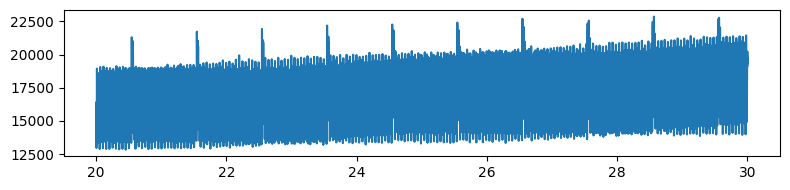

In [ ]:
sample_x, sample_y = ds_para.load_curve(growth='temp350', spot='spot_1', metric='img_sum', x_start=0)
data = np.stack([sample_x, sample_y], 1)
data = select_range(data, 20, 30)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.tight_layout()
plt.show()  

In [ ]:
downsampling_factor = 100  # 2000 Hz / 20 Hz
filter_size = 10  # Adjust the filter size as needed
low_pass_filter = np.ones(filter_size) / filter_size
filtered_data = np.convolve(data[:,1], low_pass_filter, mode='same')
downsampled_data = filtered_data[::downsampling_factor]
x_downsampled = data[::downsampling_factor,0]

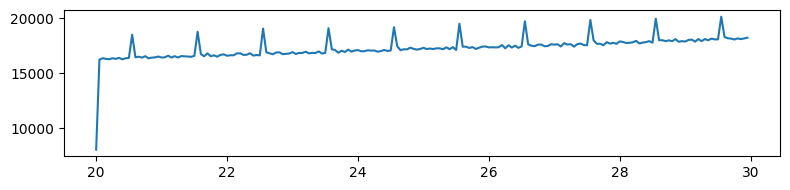

In [ ]:
plt.subplots(1, 1, figsize=(8,2))
plt.plot(x_downsampled, downsampled_data)
plt.tight_layout()
plt.show()  

In [ ]:
data.shape

(19999, 2)

In [ ]:
import numpy as np

# Calculate the number of values to average in each group
values_per_group = 100

# Calculate the total number of groups (20 groups for 2000 values)
num_groups = len(data[:,1]) // values_per_group

# Reshape the data into groups
data_groups = data[:,1][:num_groups * values_per_group].reshape(-1, values_per_group)

# Calculate the mean (average) of each group along the rows
averaged_data = np.sum(data_groups, axis=1)

In [ ]:
from datafed.CommandLib import API

api = API(opts={"client_cfg_dir": "./"})
import os
os.mkdir("./")
api.cfg.save()


FileExistsError: [WinError 183] Cannot create a file when that file already exists: './'

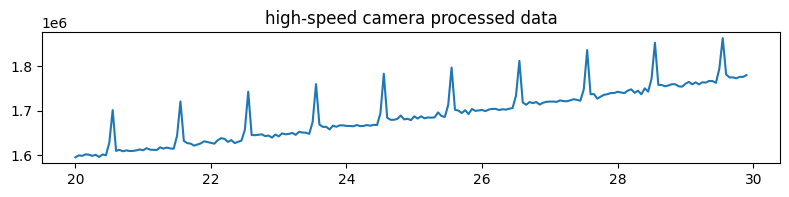

In [ ]:
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[::100,0][:199], averaged_data)
plt.tight_layout()
plt.title('high-speed camera processed data')
plt.show()

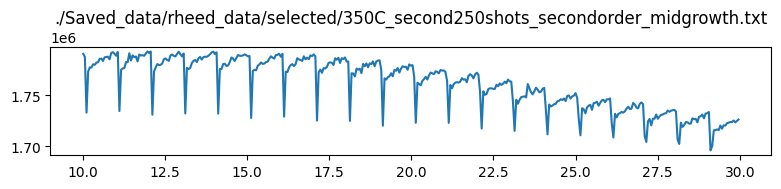

In [ ]:
file = './Saved_data/rheed_data/selected/350C_second250shots_secondorder_midgrowth.txt'
data = np.loadtxt(file)
data = select_range(data, 10, 30)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

In [ ]:
for file in glob.glob('./Saved_data/rheed_data/')
file = './Saved_data/rheed_data/selected/350C_second250shots_secondorder_midgrowth.txt'
data = np.loadtxt(file)
data = select_range(data, 10, 30)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (28030955.py, line 1)

## 2. Analyze the Decay Curve

### 2.1 J14-300C

img_mean-spot_1


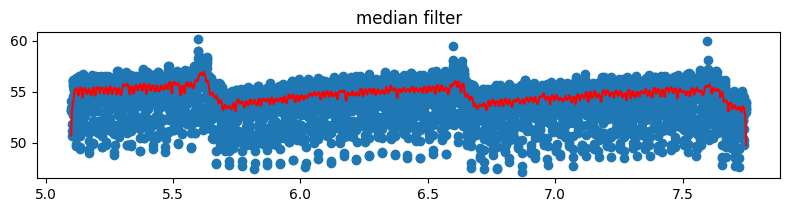

img_mean-spot_2


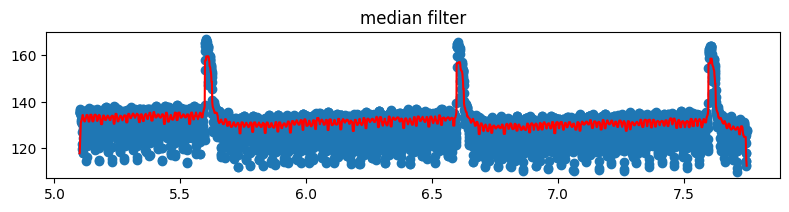

img_sum-spot_1


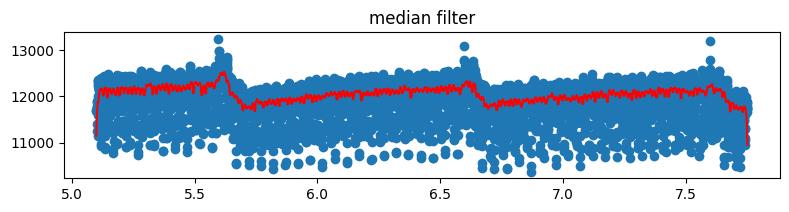

img_sum-spot_2


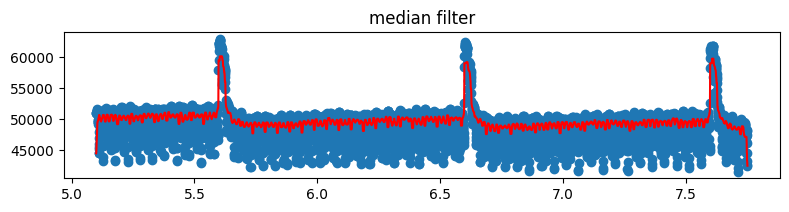

img_max-spot_1


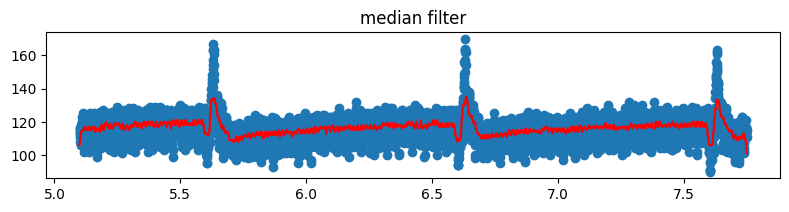

img_max-spot_2


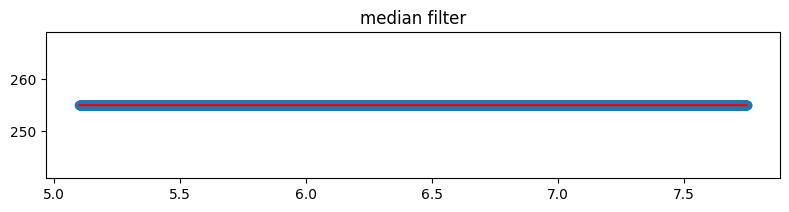

img_rec_sum-spot_1


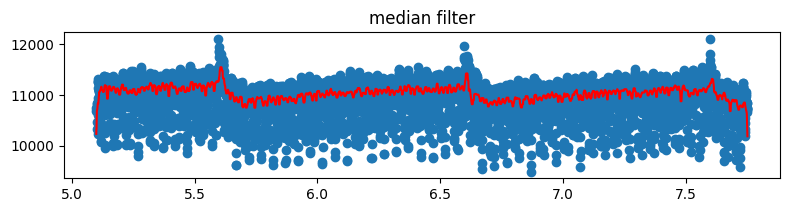

img_rec_sum-spot_2


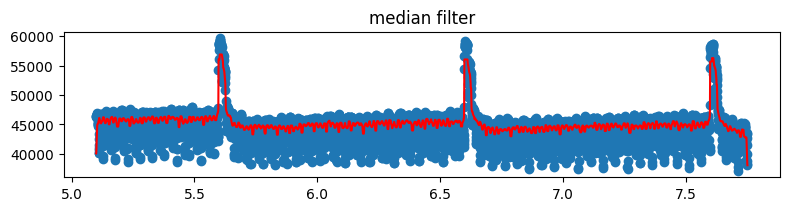

img_rec_max-spot_1


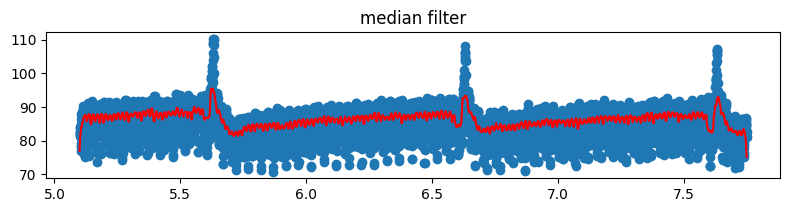

img_rec_max-spot_2


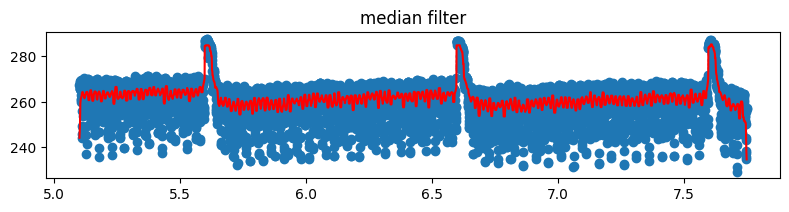

img_rec_mean-spot_1


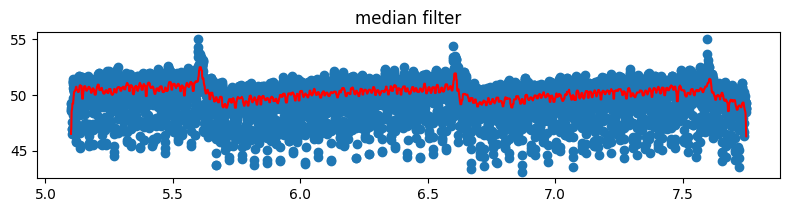

img_rec_mean-spot_2


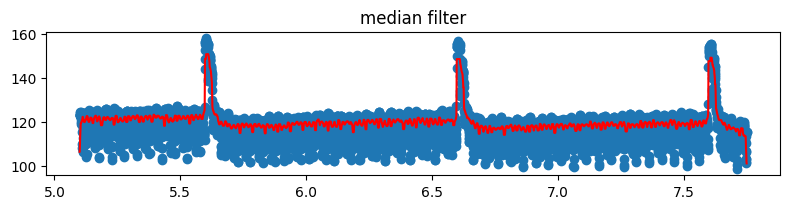

height-spot_1


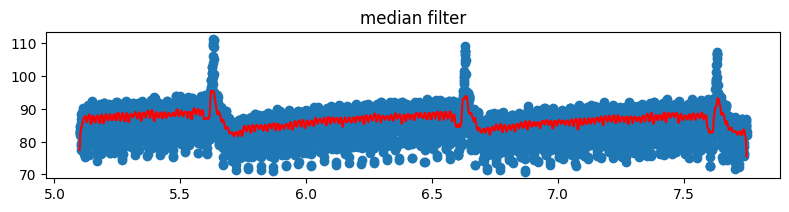

height-spot_2


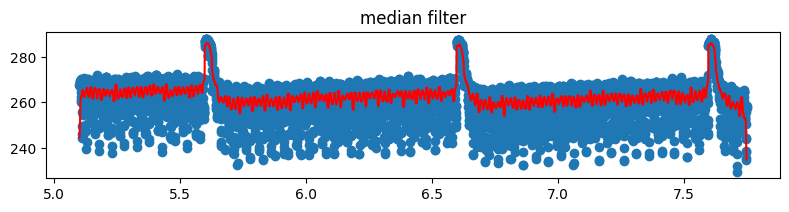

x-spot_1


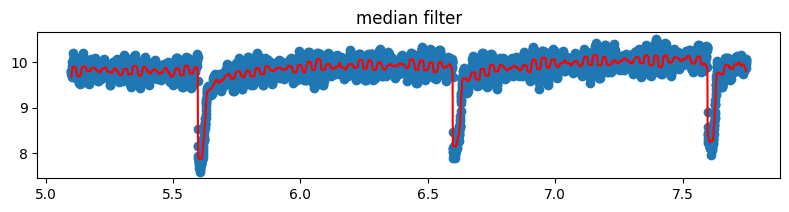

x-spot_2


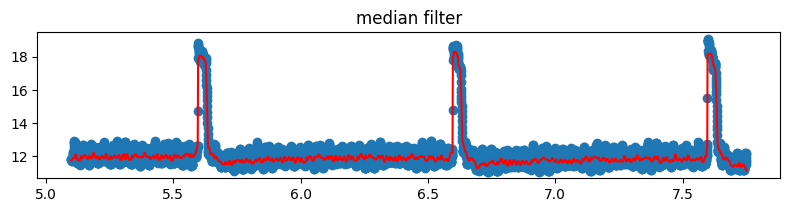

y-spot_1


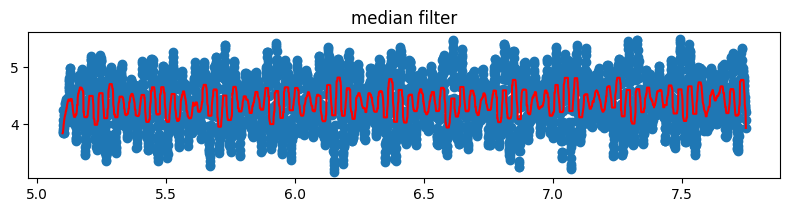

y-spot_2


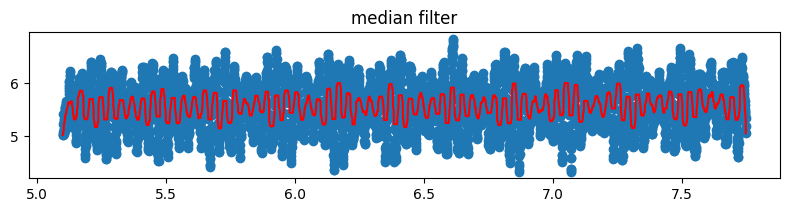

width_x-spot_1


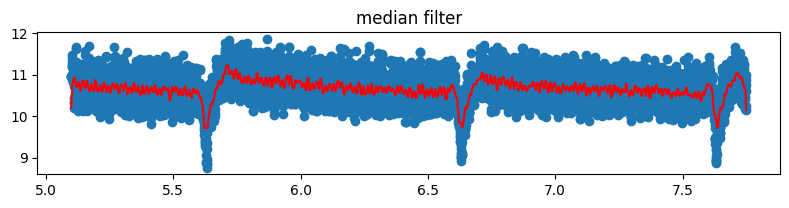

width_x-spot_2


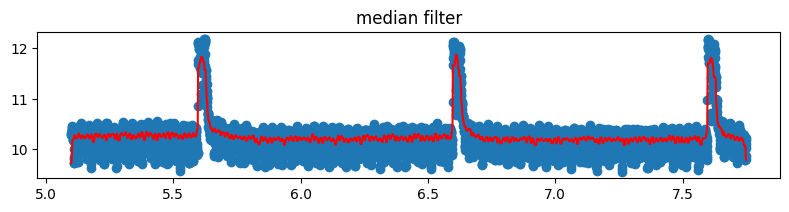

width_y-spot_1


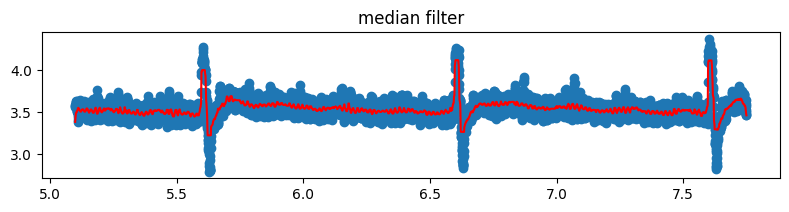

width_y-spot_2


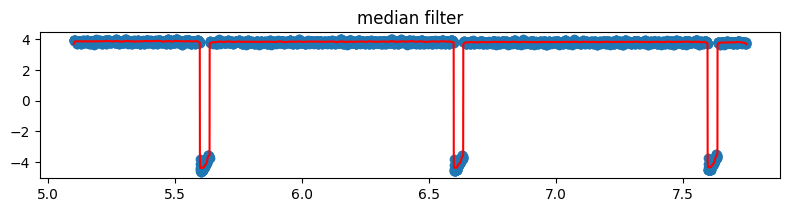

In [ ]:
for m in ["img_mean", "img_sum", "img_max", "img_rec_sum", "img_rec_max", "img_rec_mean", 
        "height", "x", "y", "width_x", "width_y"]:
    # for m in ["img_sum", "img_rec_sum"]:
    for spot in ['spot_1', 'spot_2']:
        x, y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)
        sample_x, sample_y = x[10200:15500], y[10200:15500]
        print(m+'-'+spot)
        data = np.stack([sample_x, sample_y], 1)
#         plt.figure(figsize=(8,2))
#         plt.scatter(sample_x, sample_y)
#         plt.title(m+'-'+spot)
#         plt.show()
        
#         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
        sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

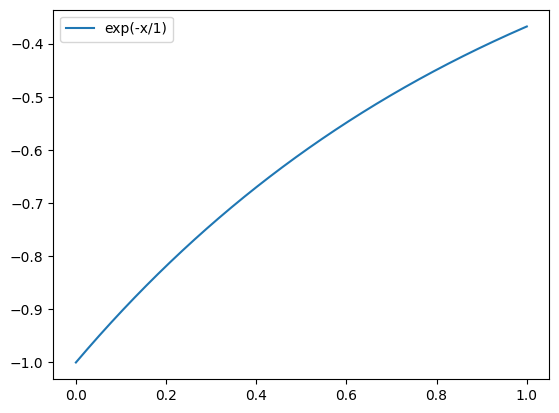

In [ ]:
x = np.linspace(0, 1, 1000)
y = -np.exp(-x/1)
plt.plot(x, y)
plt.legend(['exp(-x/1)'])

### possible metrics

img_rec_sum-spot_2


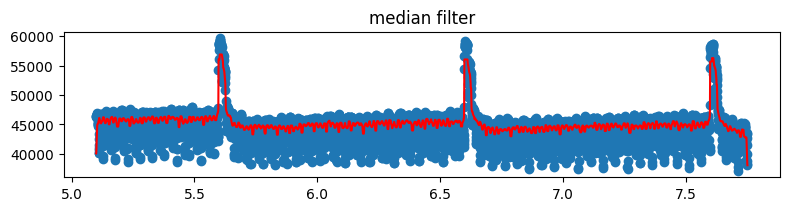

img_rec_max-spot_2


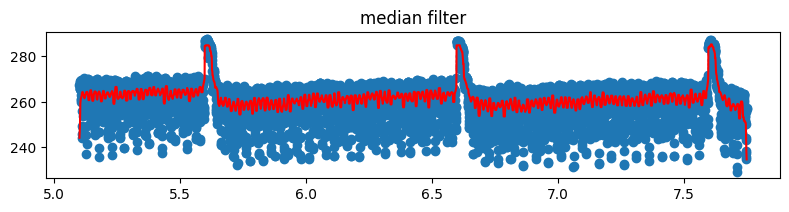

height-spot_2


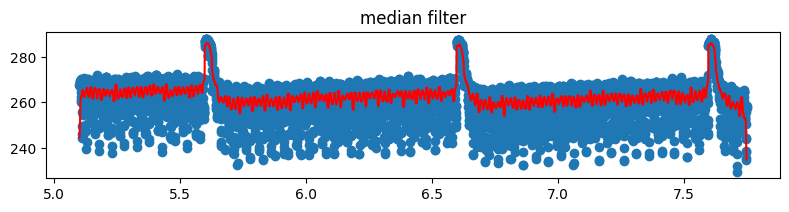

x-spot_1


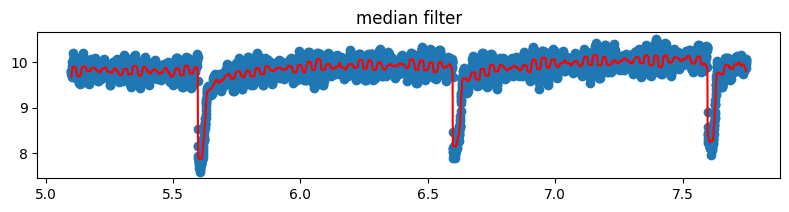

width_x-spot_1


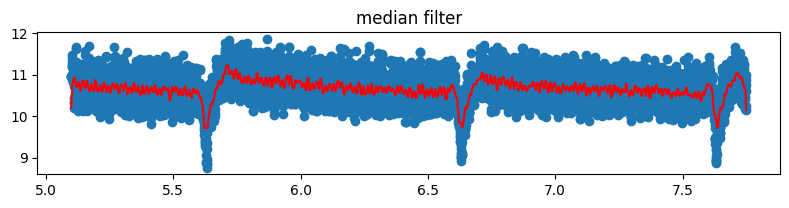

In [ ]:
for m_spot in [ ("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_2'), ("height", 'spot_2'), ("x", 'spot_1'), ("width_x", 'spot_1')]:
        m, spot = m_spot
        x, y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)
        sample_x, sample_y = x[10200:15500], y[10200:15500]
        print(m+'-'+spot)
        data = np.stack([sample_x, sample_y], 1)
        sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

In [ ]:
# for m_spot in [ ("img_rec_sum", 'spot_1'), ("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_1'), ("img_rec_max", 'spot_2'), 
#                 ("height", 'spot_1'), ("height", 'spot_2'), ("x", 'spot_1'), ("x", 'spot_2'), 
#                 ("width_x", 'spot_1'), ("width_x", 'spot_2'), ("width_y", 'spot_1')]:
#         m, spot = m_spot
#         sample_x, sample_y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)
#         print(m+'-'+spot)
#         data = np.stack([sample_x, sample_y], 1)
#         # sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)
#         sample_x, sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=5, denoise_order=1, sample_frequency=2000, viz=True)

('img_rec_sum', 'spot_2')


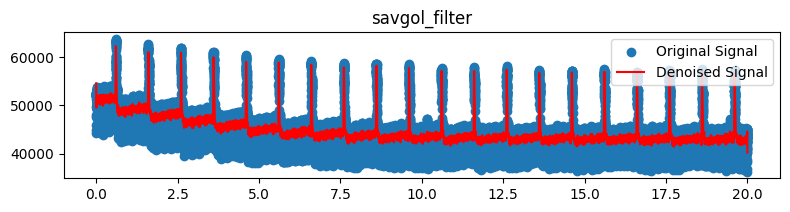

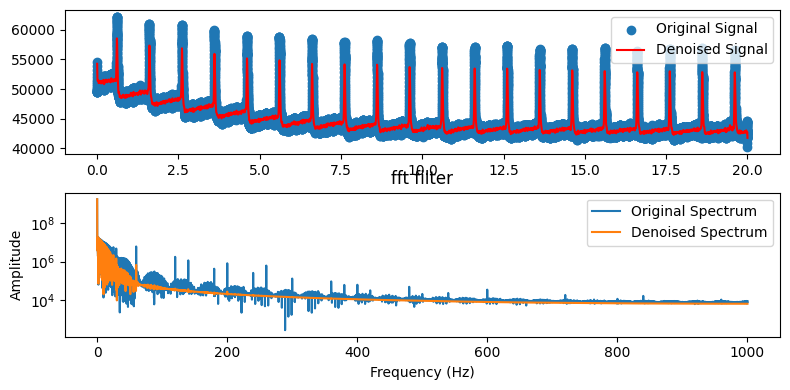

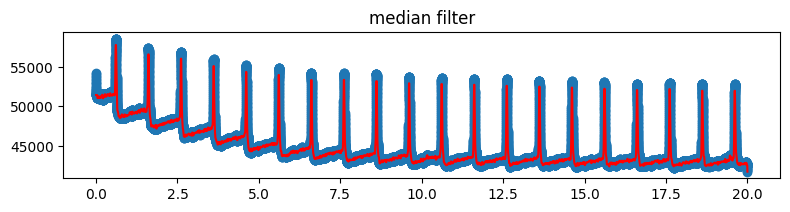

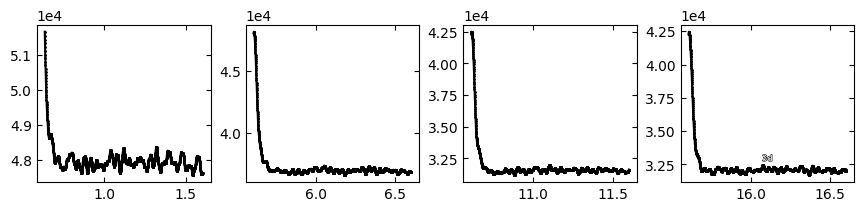

50612.15597251156 47614.10549900856
55194.11855582346 45107.81075084926
53722.73520353925 43221.79455810768
51716.51644419492 41220.89933623646
50117.327521327185 39543.92407648768
47834.88852231374 36870.314559293845
46944.21128344899 36248.87663149711
46105.96546959471 35148.8676376354
44716.42733787624 33717.242545489404
45789.69585928539 35234.702287461376
42275.30156781114 31500.53743536192
42571.396383578 32079.520707208823
42074.732851294444 31420.68781805033
41491.900561412454 31077.024632080072
41146.08330909289 30742.12678506836
42194.676400034696 32045.917307420877
40922.126961647715 30733.26833852185
39288.20087618847 28849.907825534898
36660.86290977613 26365.8347561135


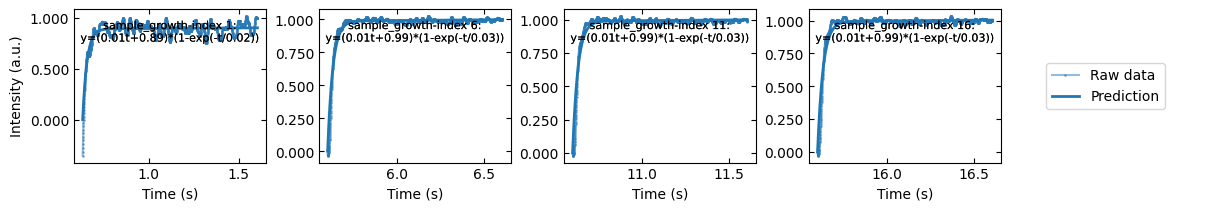

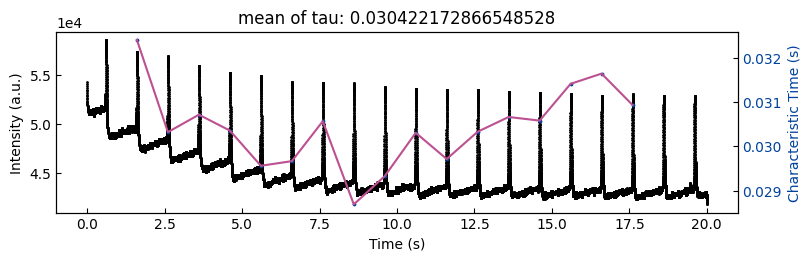

In [ ]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 20)]
m_spot_list = [("img_rec_sum", 'spot_2')]

for m_spot, ranges in zip(m_spot_list, ranges_list):

    print(m_spot)
    m, spot = m_spot
    sample_x, sample_y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)

    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)

('img_rec_sum', 'spot_2')


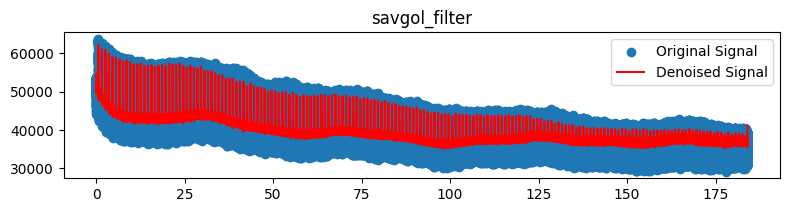

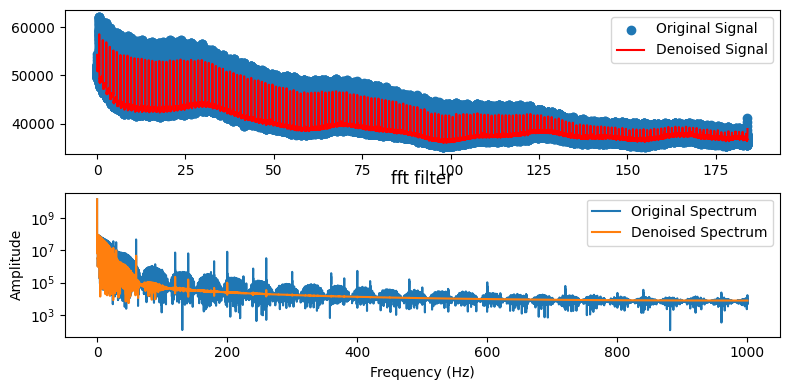

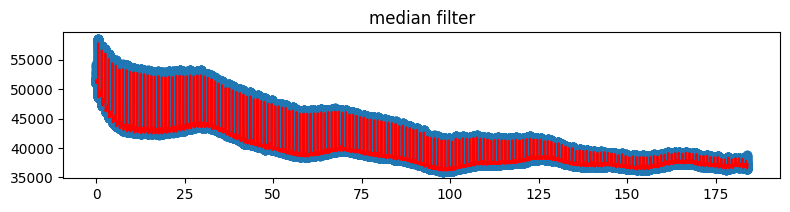

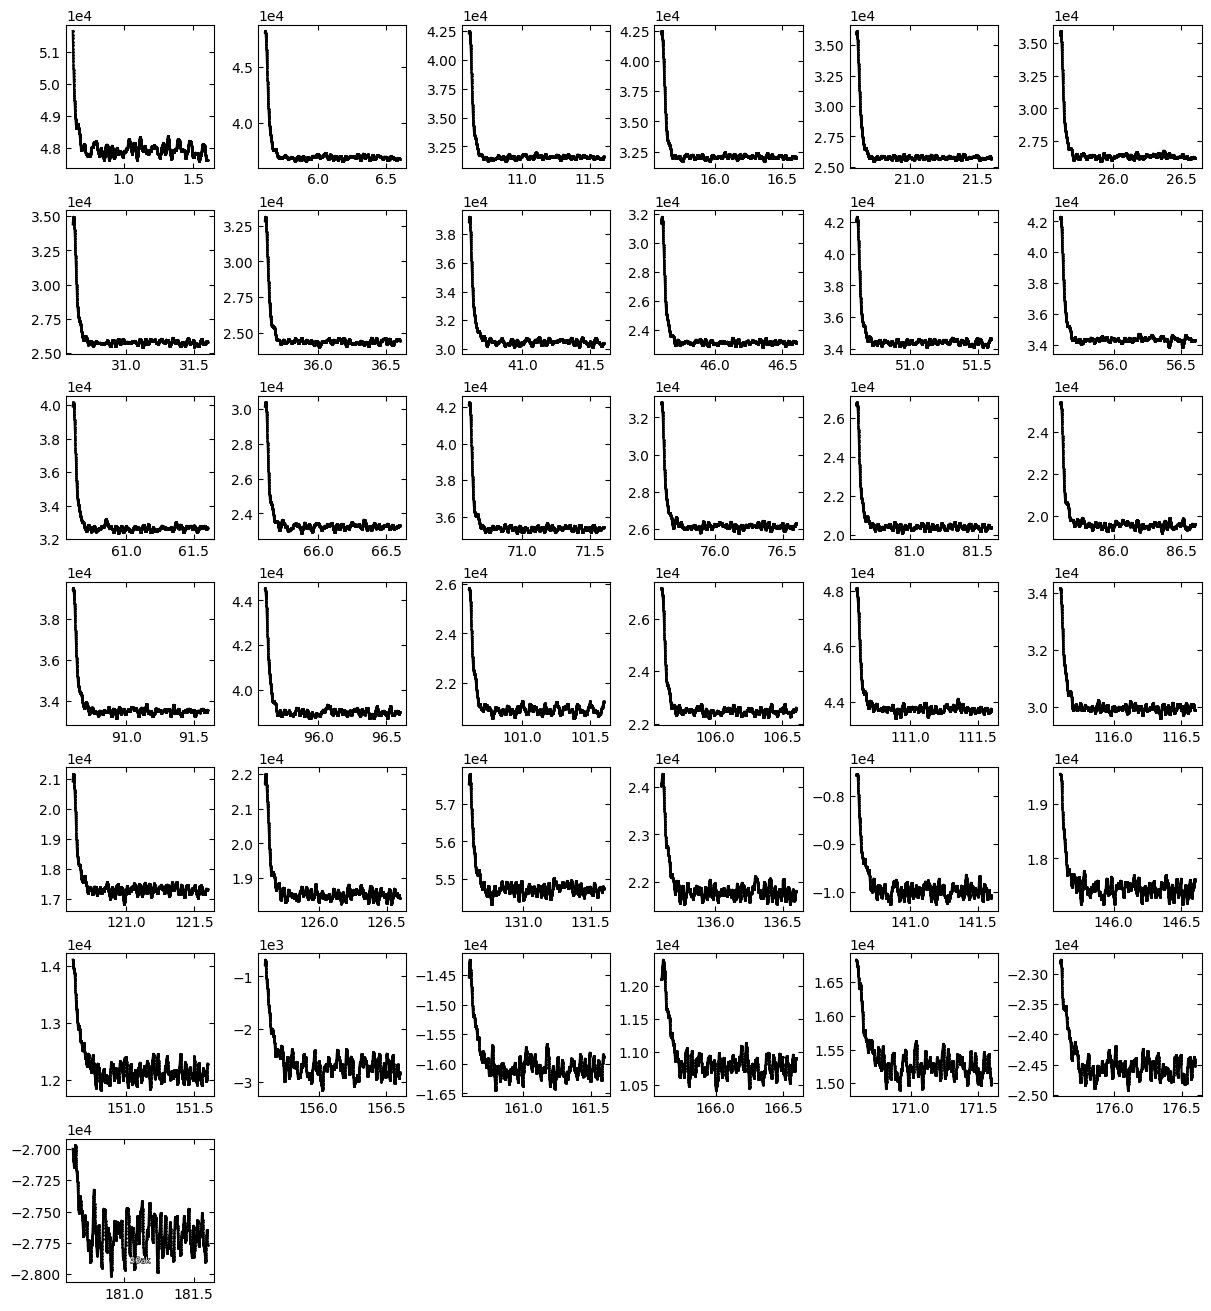

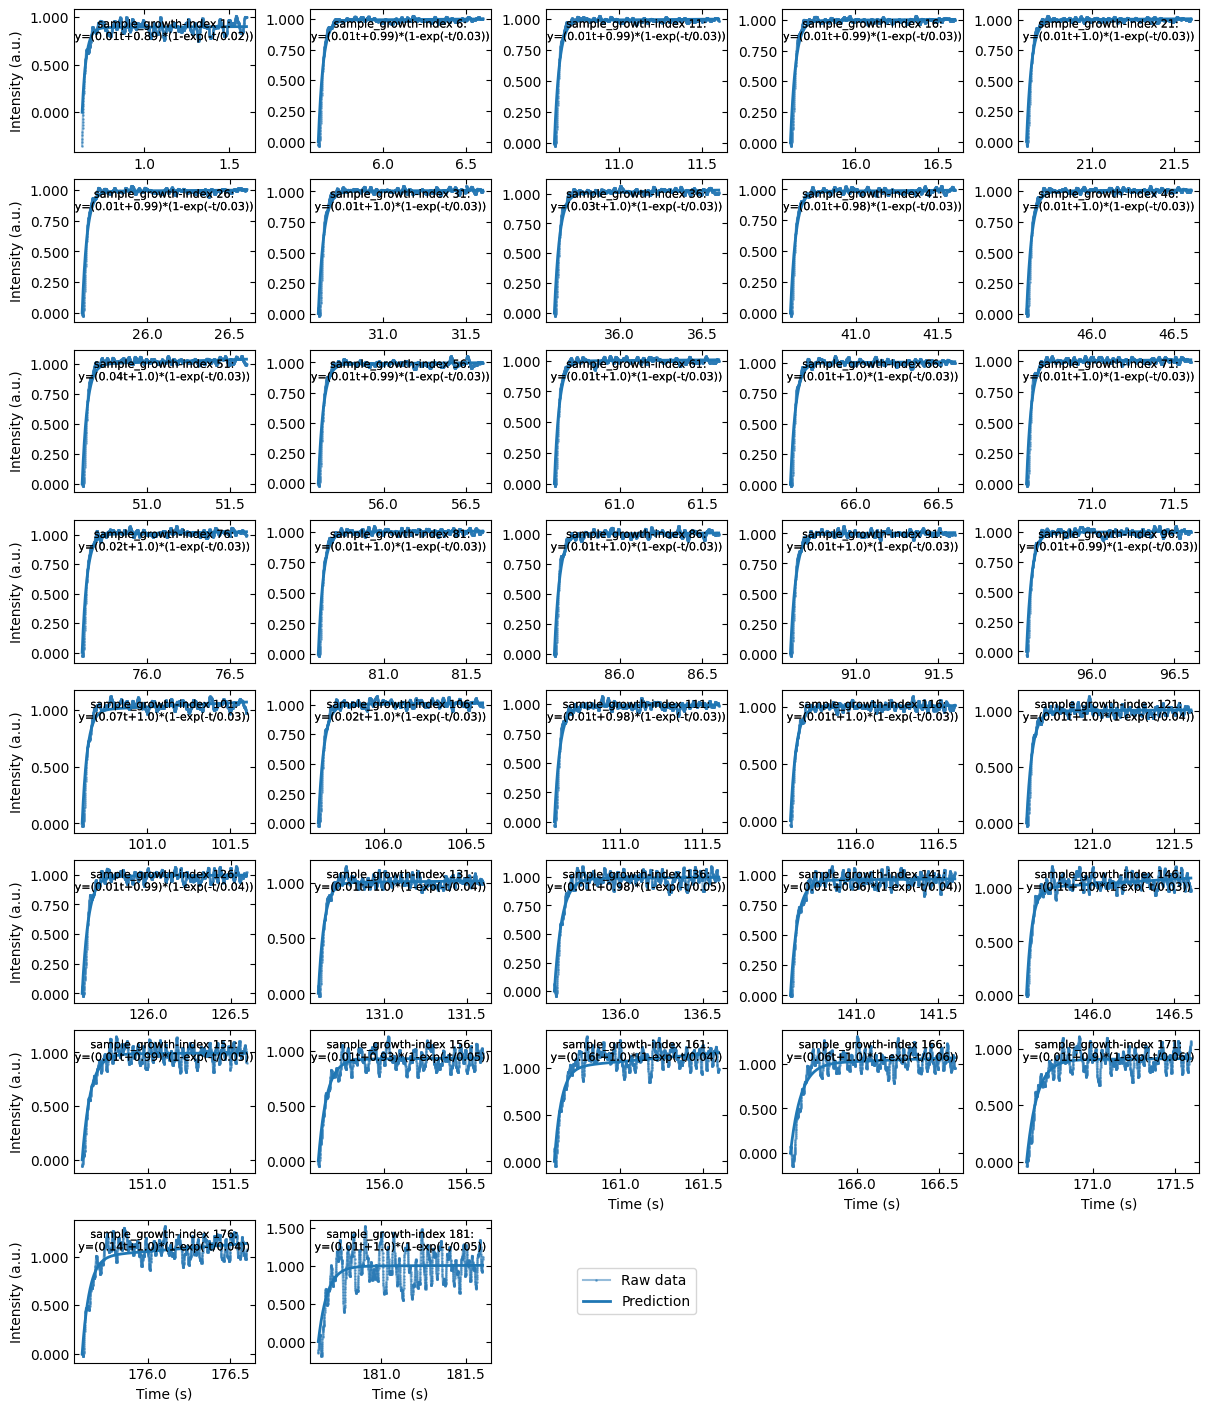

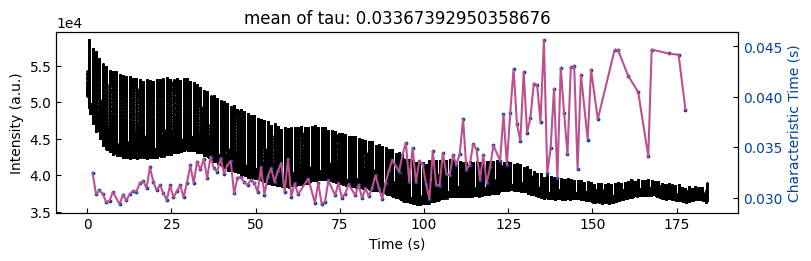

('img_rec_max', 'spot_2')


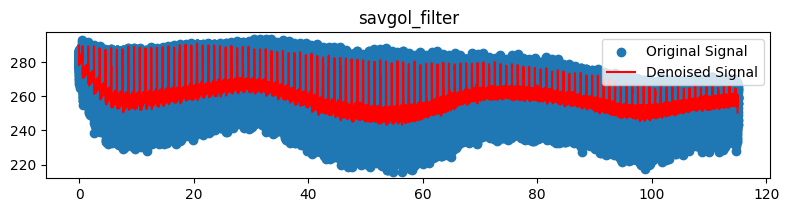

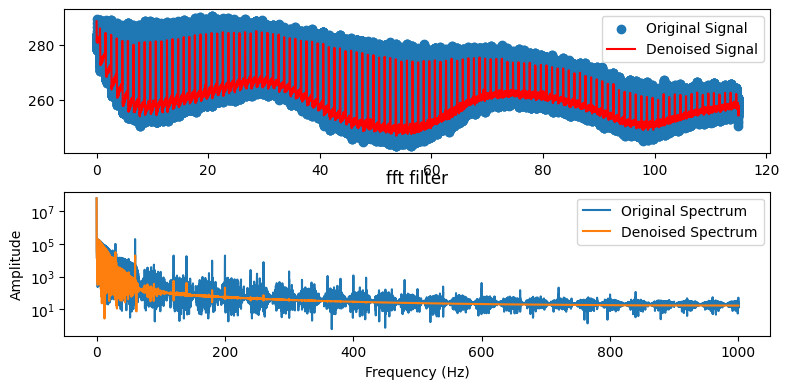

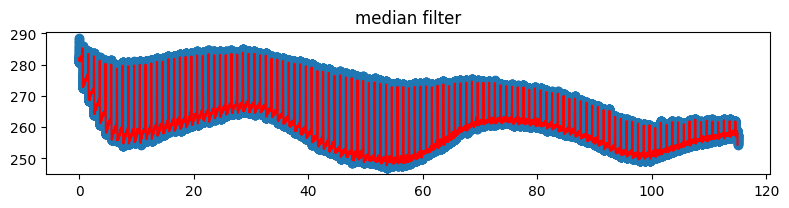

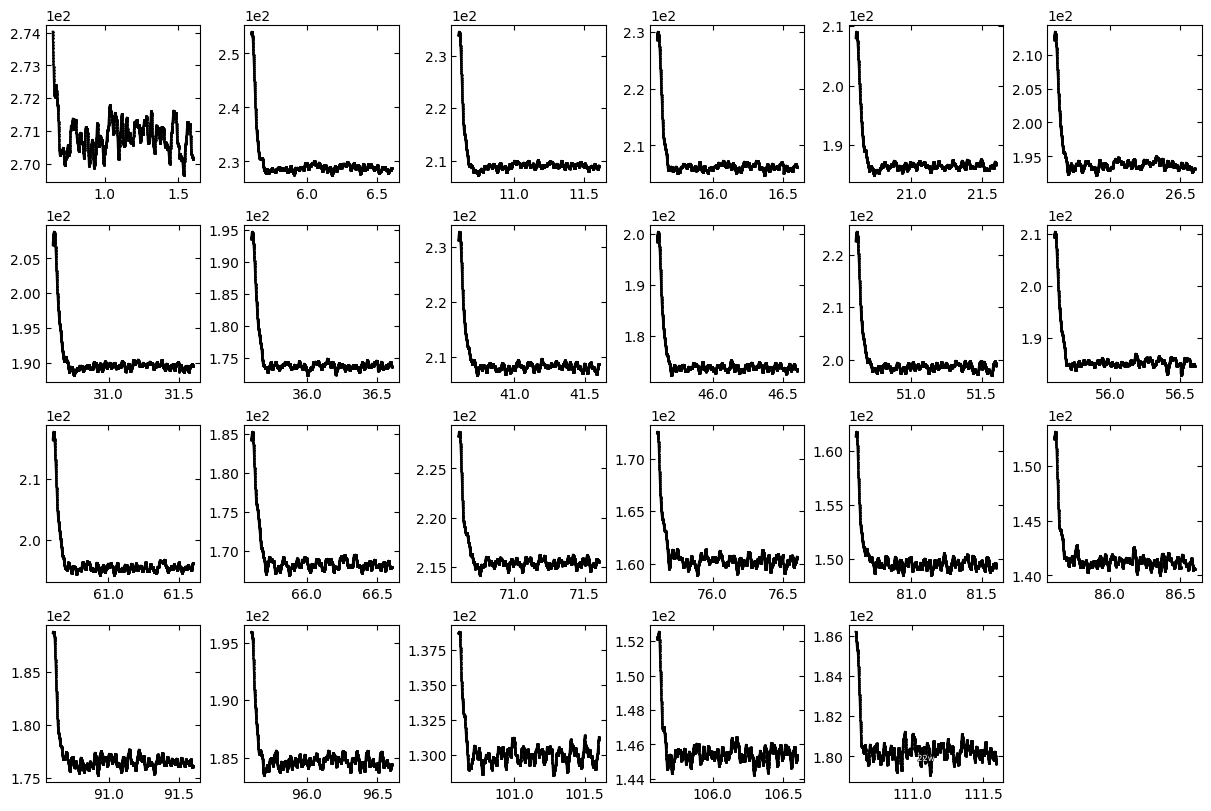

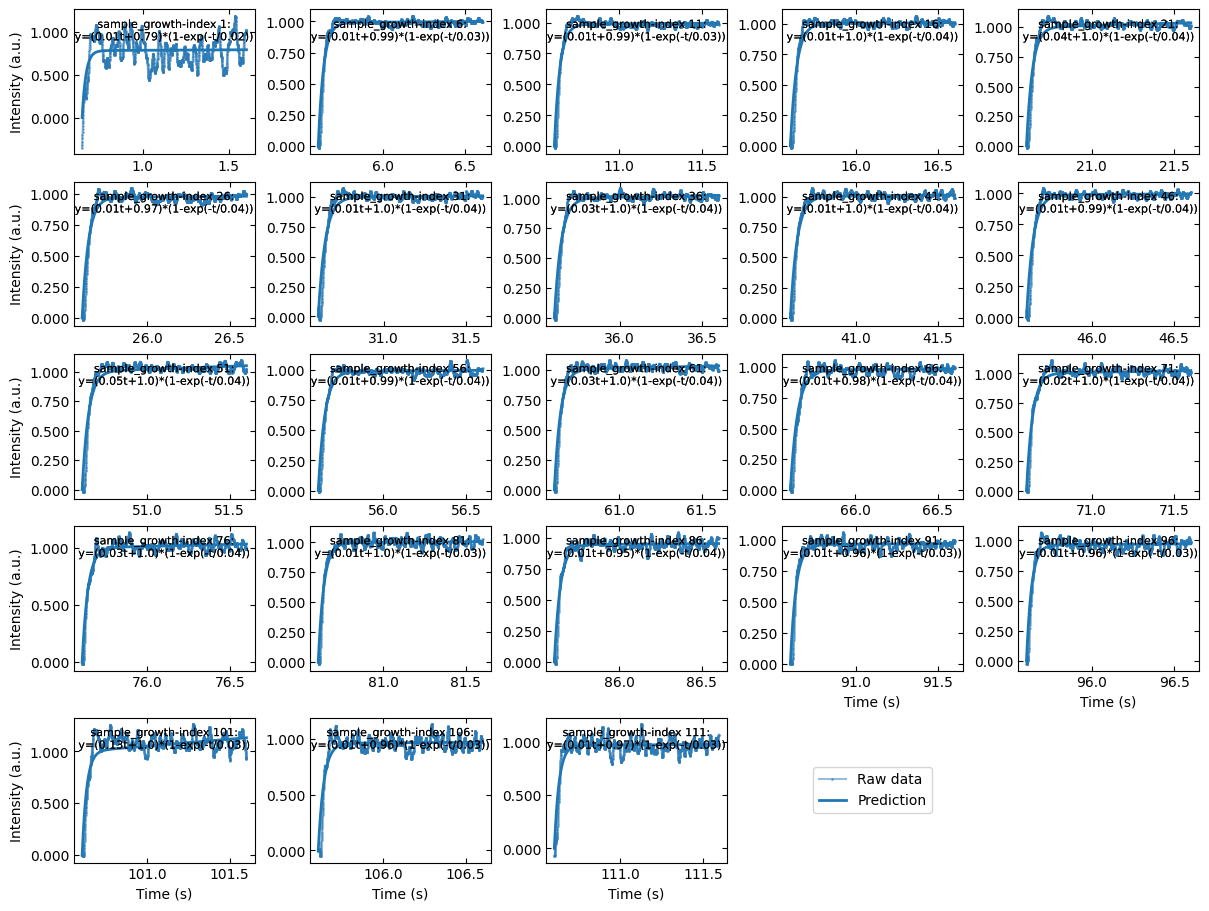

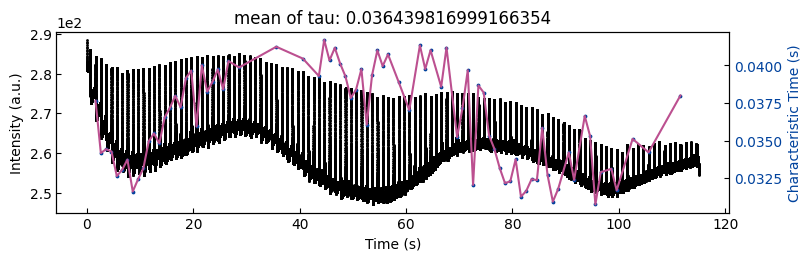

('height', 'spot_2')


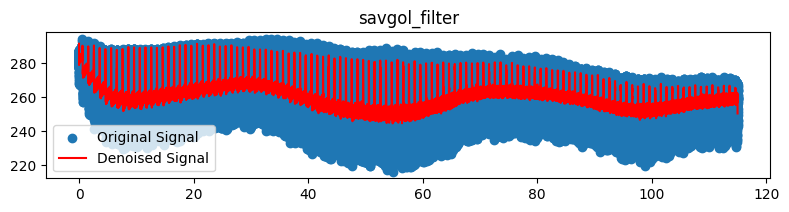

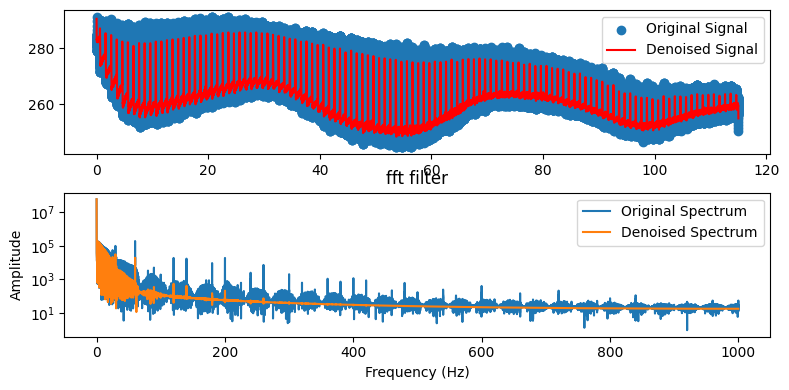

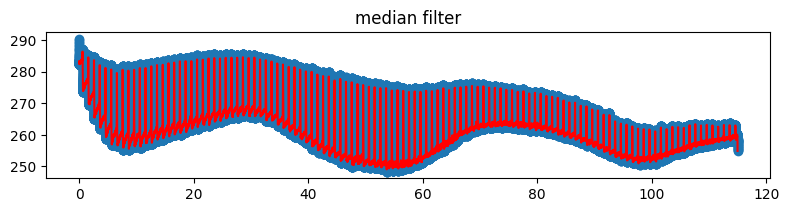

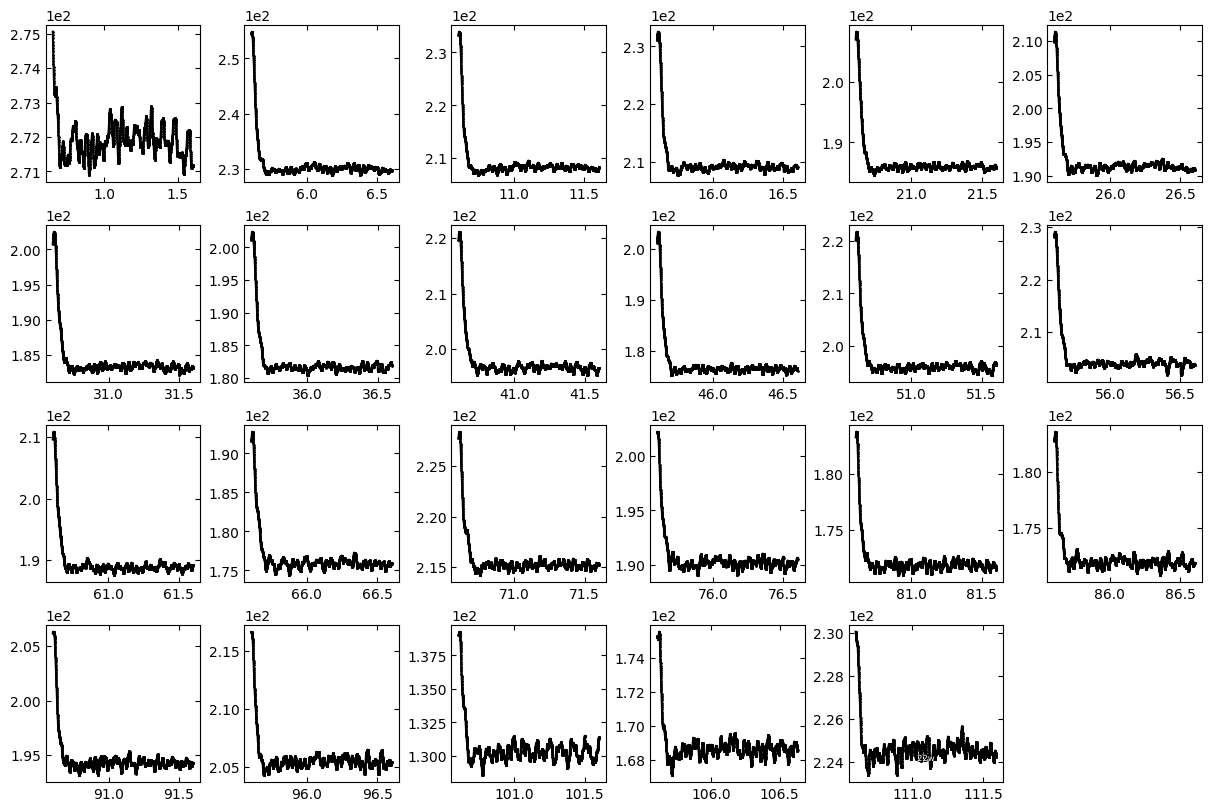

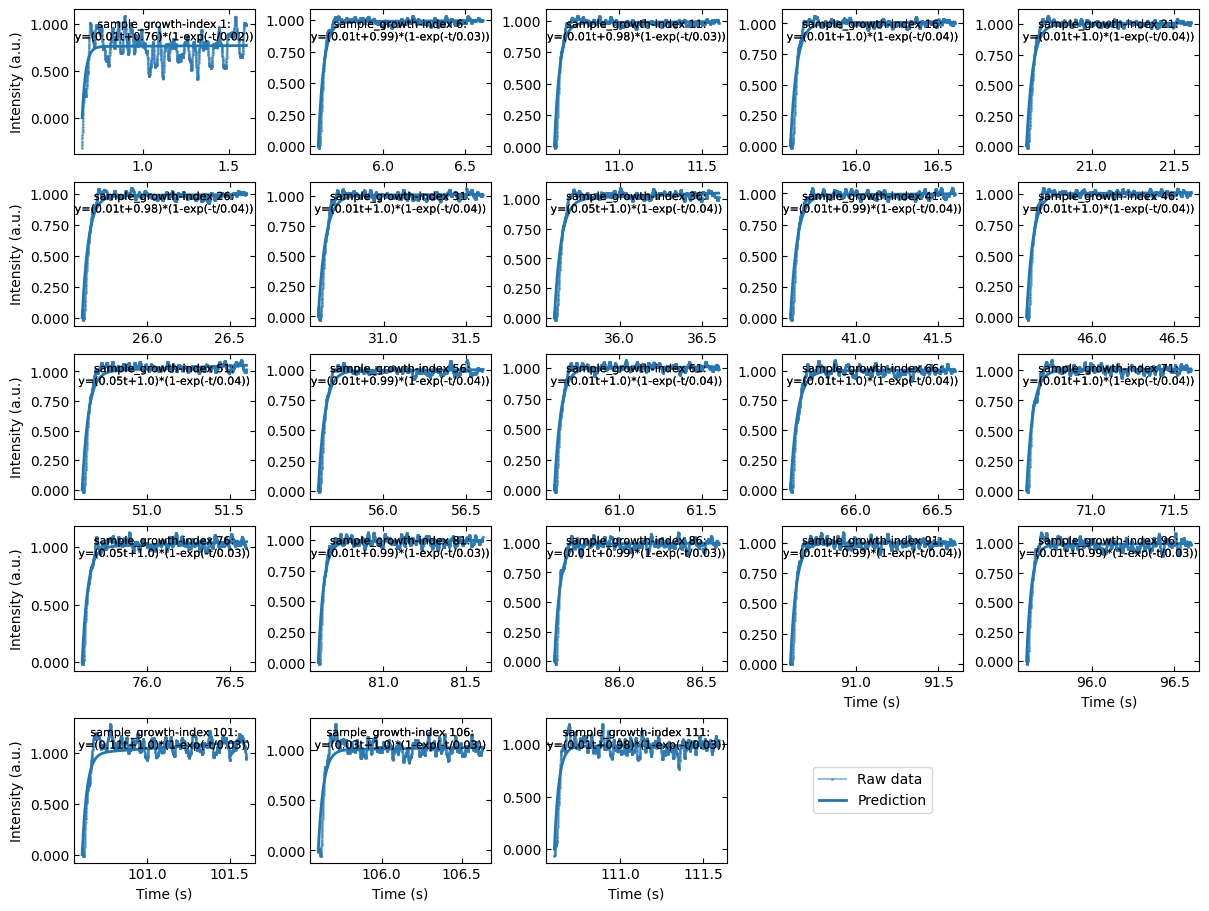

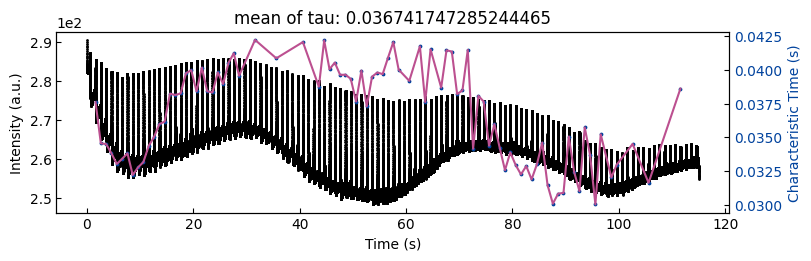

('x', 'spot_1')


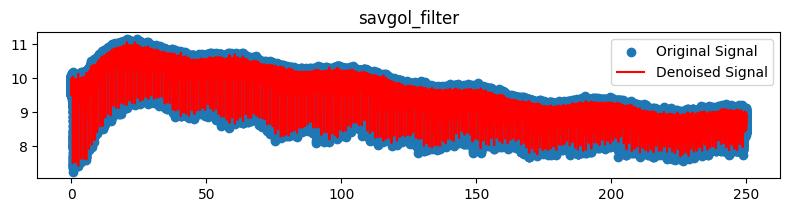

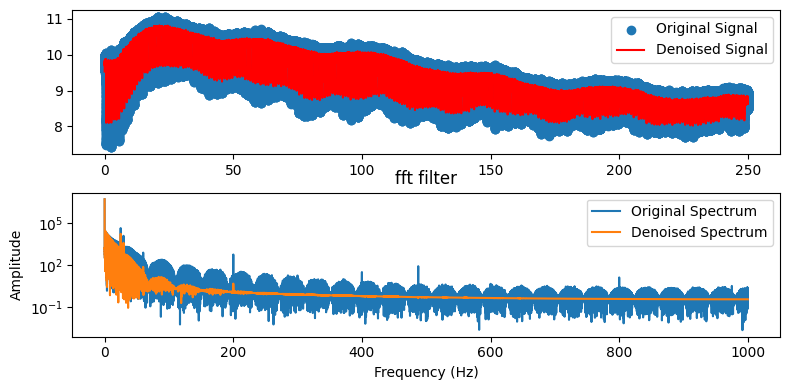

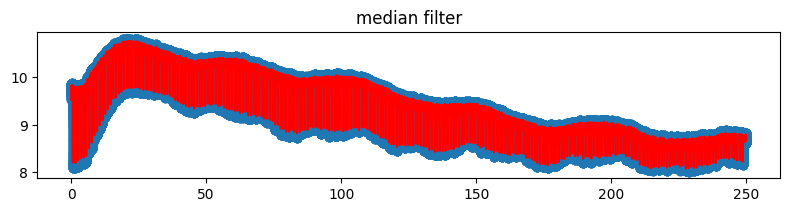

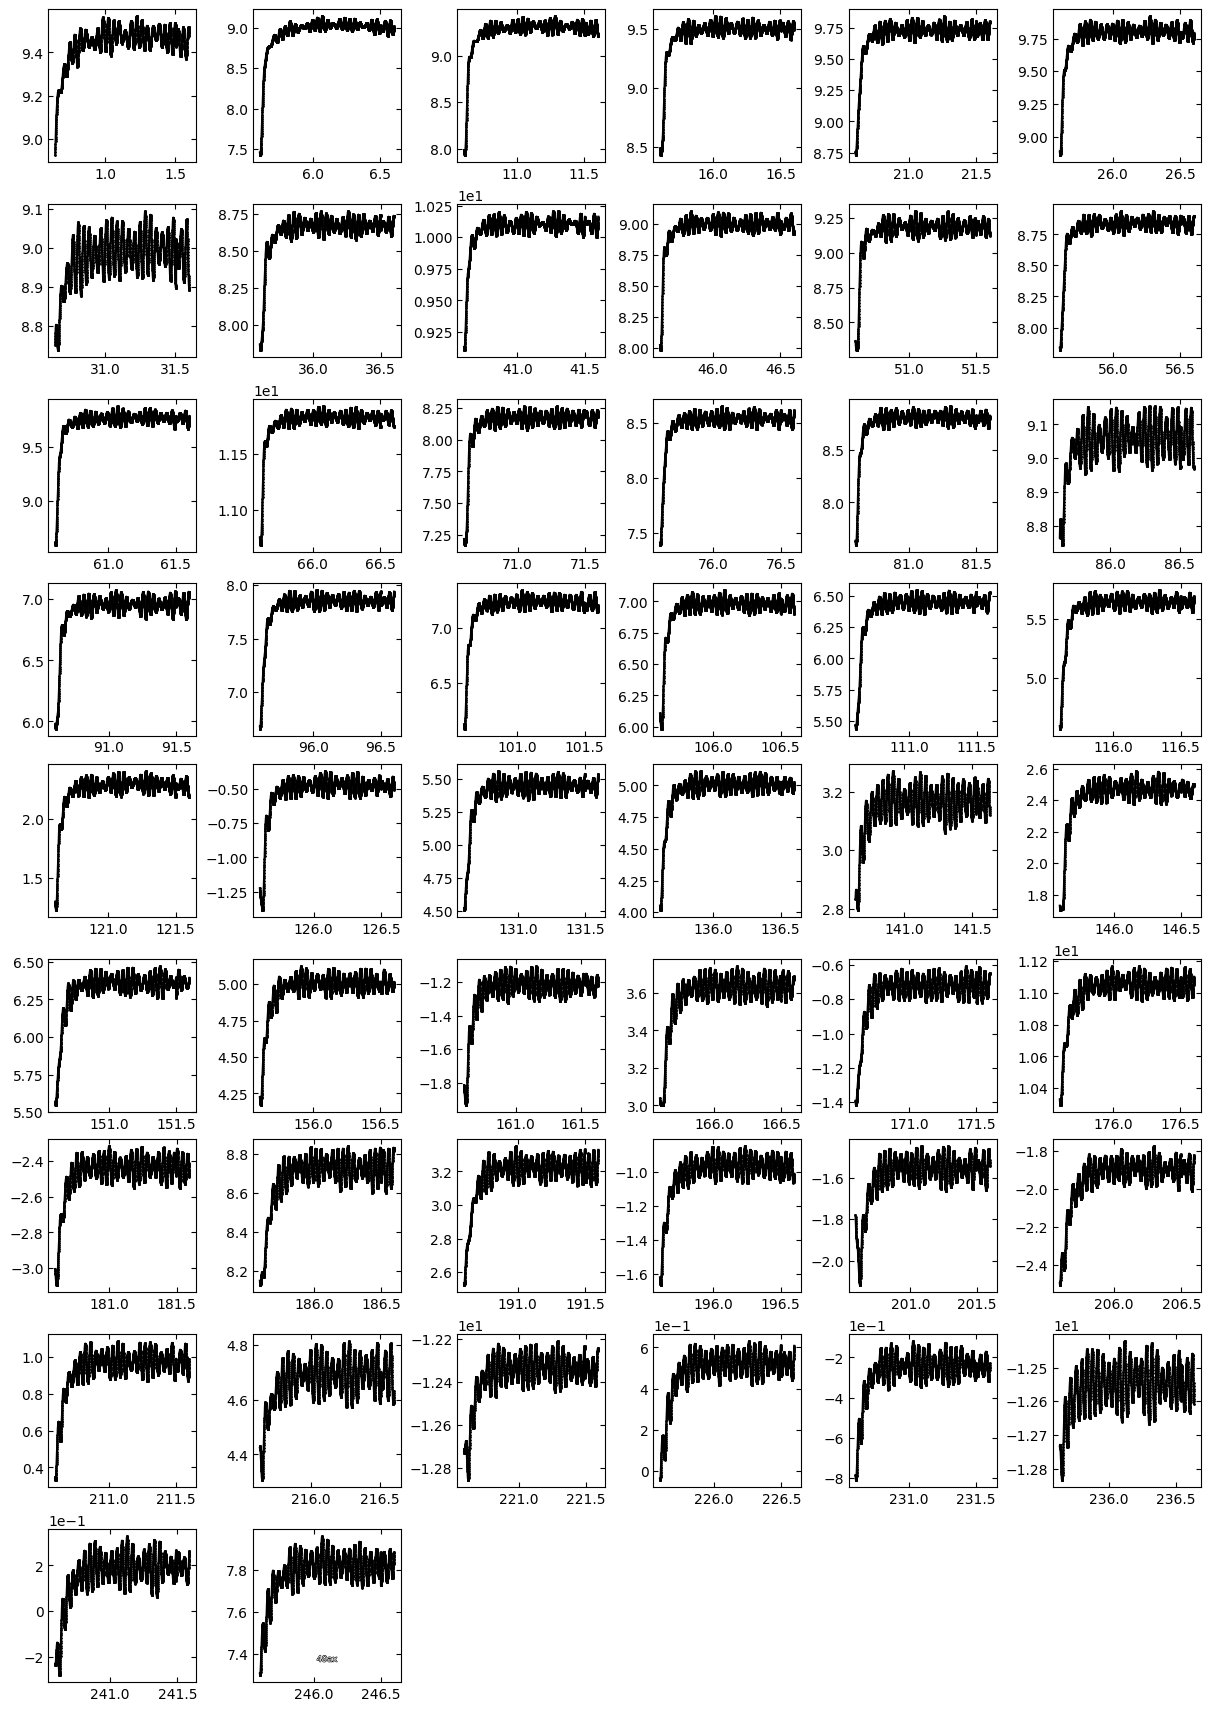

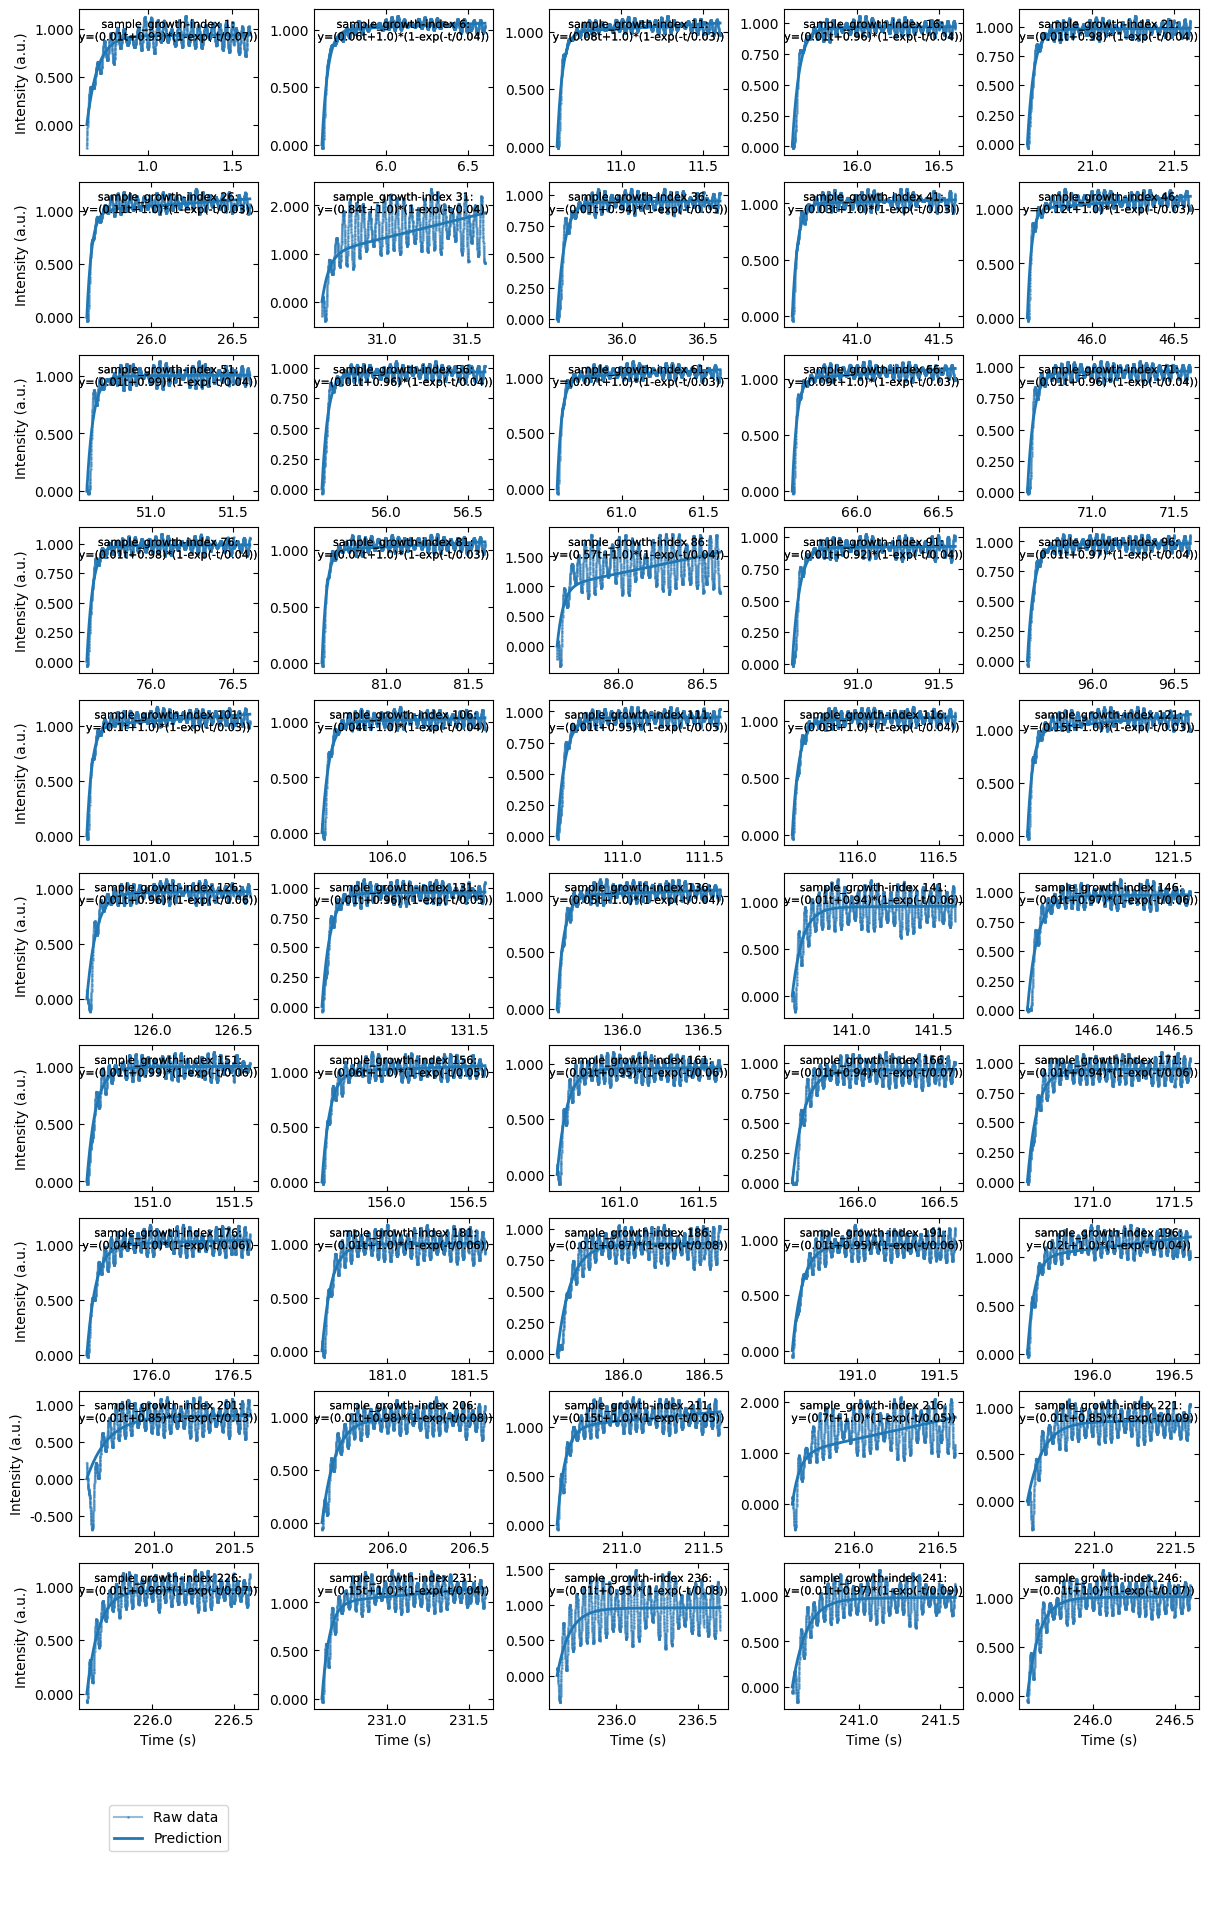

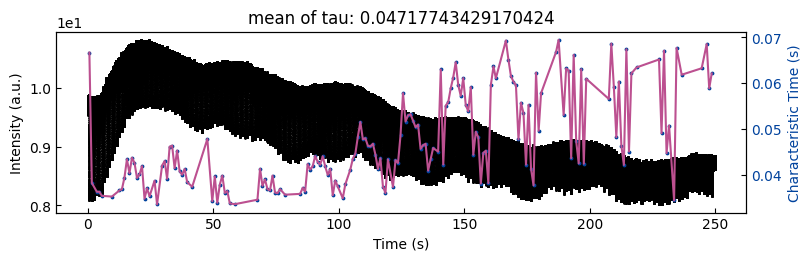

In [ ]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 184), (0, 115), (0, 115), (0, 260)]
m_spot_list = [("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_2'), ("height", 'spot_2'), ("x", 'spot_1')]

for m_spot, ranges in zip(m_spot_list, ranges_list):

    print(m_spot)
    m, spot = m_spot
    sample_x, sample_y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)

    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)

('img_rec_sum', 'spot_2')


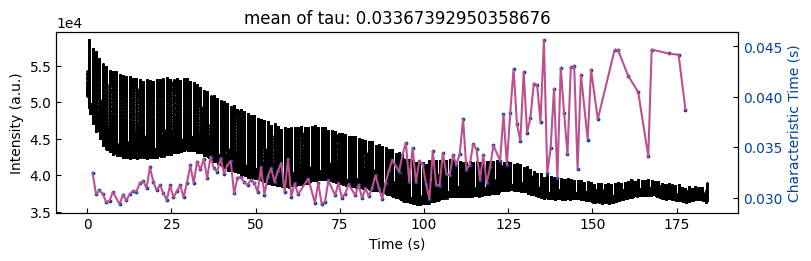

('img_rec_max', 'spot_2')


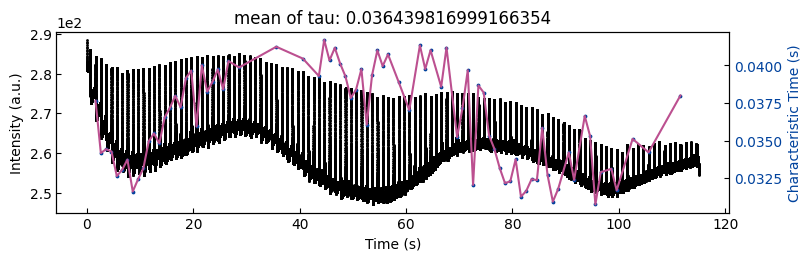

('height', 'spot_2')


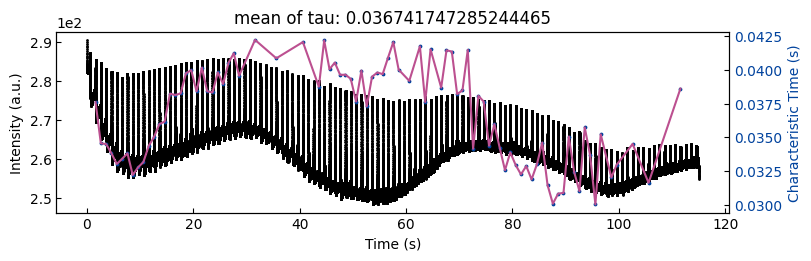

('x', 'spot_1')


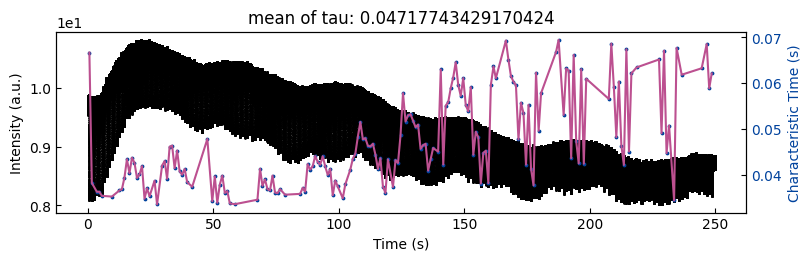

In [ ]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 184), (0, 115), (0, 115), (0, 260)]
m_spot_list = [("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_2'), ("height", 'spot_2'), ("x", 'spot_1')]

for m_spot, ranges in zip(m_spot_list, ranges_list):

    print(m_spot)
    m, spot = m_spot
    sample_x, sample_y = ds_para.load_curve(growth='temp250', spot=spot, metric=m, x_start=0)

    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)